# Using thermodynamic analysis to guide metabolic engineering
DO 12-6-2018  
Using Python 3 and eQuilibrator API  


In [2]:
#Changing directory to the github home folder /Ctherm_thermo
import os
os.chdir('/Users/satyakam/Dropbox/work/equilibrator-api-master')
import sys
sys.path.append('/Users/satyakam/Dropbox/work/sbtab-0.9.64')
#sys.path.append('/Users/satyakam/Dropbox/work/equilibrator-api-master')
#sys.path.append('/Users/satyakam/Dropbox/work/equilibrator-api-master/src/equilibrator_api')
sys.path.append('/Users/satyakam/Dropbox/work/equilibrator-api-master/src')
#sys.path.append('/Users/satyakam/Dropbox/work')


In [3]:
import numpy as np
from numpy import array, eye, log, zeros, matrix
from numpy.linalg import inv, solve
import pandas as pd
from equilibrator_api import Reaction, ComponentContribution, ReactionMatcher, CompoundMatcher, ParseError, Pathway
from equilibrator_api.bounds import Bounds
%matplotlib inline

## Set up translator for KEGG IDs
Note: I set these up as dataframes because I was troubleshooting an issue with duplicate KEGG IDs. Eventually I think these should be set up as dictionaries, to make the code more readable

In [4]:
# make a dictionary to translate KEGG IDs into human-readable abbreviations
keggTranslatorDf = pd.read_excel('KEGG_SEED_DO.xls')
kt = keggTranslatorDf #short name for easier typing

# translate KEGG ID to abbreviation
kta = kt.loc[:,['KEGG ID(S)', 'ABBREVIATION']]
kta['KEGG ID(S)'] = kta['KEGG ID(S)'].str.lower() # set to lower case for better matching
kta['ABBREVIATION'] = kta['ABBREVIATION'].str.lower() # set to lower case for better matching
kta.set_index('KEGG ID(S)', inplace = True)

# translate abbreviation to KEGG ID
atk = kt.loc[:,['ABBREVIATION', 'KEGG ID(S)']].sort_values(by = ['KEGG ID(S)'], ascending = True)
atk['KEGG ID(S)'] = atk['KEGG ID(S)'].str.lower() # set to lower case for better matching
atk['ABBREVIATION'] = atk['ABBREVIATION'].str.lower() # set to lower case for better matching
atk = atk.groupby('ABBREVIATION').first() # take the first KEGG ID in each group

atkDict = dict(zip(atk.index, atk['KEGG ID(S)'].str.upper()))
ktaDict = dict(zip(kta.index.str.upper(), kta['ABBREVIATION'].values))

## Set up model
* Choose reactions
* Set fluxes
* Set concentration bounds
* Set pH and ionic strength

In [5]:
os.chdir('/Users/satyakam/Dropbox/work/component_contribution_ctherm')

In [6]:
allRxnDf = pd.read_excel('cth_thermo_model_DO_SD6.xlsx', sheet_name = 'reactions')
allRxnDf

,Name,PlaintextFormula,AbbreviationFormula,KeggFormula,Notes,ppi-pfk,atp-pfk,mal-snt,pdc,gapn,pyk,aldh-ndp,adh-ndp,mal-gapn,tsac
0,ATPase1,ATP + H2O <=> ADP + Pi,h2o + atp <=> adp + pi,C00002 + C00001 <=> C00008 + C00009,ATP hydrolysis for cellobiose transport,2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,CBP,Phosphate + Cellobiose <=> D-Glucose + Glucose...,pi + cellb <=> glc-D + g1p,C00009 + C00185 <=> C00031 + C00103,NaN,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2,BGL,Cellobiose + H2O <=> 2 D-Glucose,cellb + h2o <=>2 glc-D,C00185 + C00001 <=> 2 C00031,Beta glucosidase,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,GLK-GTP,D-Glucose + GTP <=> D-Glucose-6-phosphate + GDP,glc-D + gtp <=> g6p + gdp,C00031 + C00044 <=> C00092 + C00035,NaN,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4,GLK-ATP,D-Glucose + ATP <=> D-Glucose-6-phosphate + ADP,glc-D + atp <=> g6p + adp,C00031 + C00002 <=> C00092 + C00008,NaN,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
5,PGMT,Glucose-1-phosphate <=> D-glucose-6-phosphate,g1p <=> g6p,C00103 <=> C00092,NaN,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
6,PGI,D-Glucose-6-phosphate <=> D-Fructose-6-phosphate,g6p <=> f6p,C00092 <=> C00085,NaN,2,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
7,PFK-PPi,PPi + D-fructose-6-phosphate <=> Phosphate + D...,ppi + f6p <=> pi + fdp + h,C00013 + C00085 <=> C00009 + C00354 + C00080,NaN,2,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0
8,PFK-ATP,ATP + D-Fructose-6-phosphate <=> ADP + D-Fruct...,atp + f6p <=> adp + fdp,C00002 + C00085 <=> C00008 + C00354,NaN,0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
9,FBA,"D-Fructose-1,6-bisphosphate <=> Glycerone-phos...",fdp <=> dhap + g3p,C00354 <=> C00111 + C00118,NaN,2,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0


In [7]:
# choose a flux set, and drop all of the zero-flux reactions
# loop over fluxsets to generate multiple models 
selectedRxnDf={}
fluxSet = 'ppi-pfk'
for f in range(len(fluxSet)):
    selectedRxnDf = allRxnDf.loc[allRxnDf[fluxSet] != 0, ['Name', 'AbbreviationFormula', 'KeggFormula', fluxSet]]
    selectedRxnDf.rename(columns = {fluxSet:'flux'}, inplace = True) # rename the flux columns to 'flux' to simplify subsequent
    #rxnlist[f]= selectedRxnDf  

In [8]:
#Import metabolite data from excel file
Met_bound = pd.read_excel('cth_thermo_model_DO_SD6.xlsx', sheet_name = 'metabolite_bounds')
Alldata = pd.read_excel('./metabolite_data/lt_dataset2_quantified.xlsx')
Met_data = Alldata.loc[Alldata['Replicate'] != 0, ['Timepoint', 'KEGG_ID', 'compound','amount_int', 'Sample','Replicate','Maven filename']]
Met_data[:2]

,Timepoint,KEGG_ID,compound,amount_int,Sample,Replicate,Maven filename
0,2,C00197,3PG,217.958918,A,1,A1_1
1,2,C00197,3PG,137.397616,A,2,A1_2


In [9]:
Met_bound

,KEGG_ID,Name,Concentration:Max,Concentration:Min,Type,GetFromMeasured,Unnamed: 6,max (µM),min (µM)
0,C00008,adp,0.00010,0.000100,Cofactor,no,NaN,100.0,100.0
1,C00020,amp,0.00010,0.000100,Cofactor,no,NaN,100.0,100.0
2,C00002,atp,0.02000,0.001000,Cofactor,no,NaN,20000.0,1000.0
3,C00010,coa,0.02000,0.000001,Cofactor,no,NaN,20000.0,1.0
4,C00139,fdxox,0.00010,0.000100,Cofactor,NaN,NaN,100.0,100.0
5,C00138,fdxrd,0.01000,0.000001,Cofactor,NaN,NaN,10000.0,1.0
6,C00035,gdp,0.00010,0.000100,Cofactor,no,NaN,100.0,100.0
7,C00044,gtp,0.02000,0.001000,Cofactor,no,NaN,20000.0,1000.0
8,C00003,nad,0.00010,0.000100,Cofactor,no,NaN,100.0,100.0
9,C00004,nadh,0.01000,0.000001,Cofactor,no,NaN,10000.0,1.0


In [10]:
# parse the KeggFormula column to create eQuilibrator Reaction objects
# create reaction list
reactions = []
for i, row in selectedRxnDf.iterrows():
    rxn = Reaction.parse_formula(row['KeggFormula'], rid = row['Name'])
    if (rxn.check_full_reaction_balancing()):
        reactions.append(rxn)
    else:
        print('Error: reaction {} is not balanced'.format(row['AbbreviationFormula']))
        
# create flux list
fluxes = selectedRxnDf['flux'].values

# need to declare pH and ionic strength constants at the beginning
PH = 7.0
IS = 0.1

# calculate dGO_r_primes
dG0_r_primes = []
for r in reactions:
    result = r.dG0_prime(pH = PH, ionic_strength = IS)
    #print(result)
    dG0_r_primes.append(result)

In [11]:
# set up the model
pp = Pathway(reactions = reactions, fluxes = fluxes, dG0_r_primes = dG0_r_primes)

In [12]:
# impose only one concentration bound at a time to check for infeasible bounds
all_data={}
Uf = 1.5 #Uncertainity factor 
DEFAULT_LB = 1e-6
DEFAULT_UB = 2e-2 #20 mM, which is 2x higher than the 10 mM default bound suggested in the Noor et al. 2014 paper.
for sm in range(12): # divide the samples into datasets
    all_data[sm]={}
    if sm < 6:
        smple = 'A'
    else:
        smple = 'B'
    if (sm)%3==0:
        tym = 2
    elif (sm)%3==1:
        tym = 5
    else:
        tym = 9
    if sm<3 or (sm<9 and sm>5):
        rep = 1
    else:
        rep = 2
    print(smple,tym,rep)
    for i, dat in Met_data.iterrows():
        for i, cpd in Met_bound.iterrows():  # reset bounds at the start of each iteration
            pp.bounds.SetBounds(cpd['KEGG_ID'],cpd['Concentration:Min'],cpd['Concentration:Max'] )
        # skip cofactors and impose bound on metsbolites one at a time    
        if (dat['Sample']==smple and dat['Timepoint']==tym and dat['Replicate']==rep) and (dat['KEGG_ID'] not in ["C00002","C00008","C00020","C00044","C00035","C00003","C00004","C00005","C00006","C00469"]):
            all_data[sm][i]={}
            lb = dat['amount_int']/(2 *1e6)
            ub = dat['amount_int']/1e6 *Uf
            if lb < DEFAULT_LB:    
                lb = DEFAULT_LB

            if lb > DEFAULT_UB:
                lb = DEFAULT_UB

                        
   
            if ub < DEFAULT_LB:
                ub = DEFAULT_LB

            if ub > DEFAULT_UB:
                ub = DEFAULT_UB
                
            pp.bounds.SetBounds(dat['KEGG_ID'], lb, ub)
            if tym  == 2 and smple == 'A':
                pp.bounds.SetBounds('C00469', 5.12/46, 5.12/46)
            elif tym ==5 and smple == 'A':
                pp.bounds.SetBounds('C00469', 20.21/46, 20.21/46)
            elif tym ==9 and smple == 'A':
                pp.bounds.SetBounds('C00469', 40.38/46, 40.38/46)
            if tym  == 2 and smple == 'B':
                pp.bounds.SetBounds('C00469', 0.2/46, 0.2/46)
            elif tym ==5 and smple == 'B':
                pp.bounds.SetBounds('C00469', 0.47/46, 0.47/46)
            elif tym ==9 and smple == 'B':
                pp.bounds.SetBounds('C00469', 0.58/46, 0.58/46)
            mdf_data = pp.calc_mdf()
            #print(smple,tym,rep,dat['KEGG_ID'],mdf_data.mdf)
            print(dat['KEGG_ID'],mdf_data.mdf)
            all_data[sm]['sample']=smple
            all_data[sm]['timepoint']=tym
            all_data[sm]['replicate']=rep
            #all_data[sm][cpd['KEGG_ID']]['metab']=dat['KEGG_ID']
            all_data[sm]['mdf']=mdf_data
            '''
            if mdf_data.mdf>0 :
                mdf_data, con = pp.conc_mdf()
                print(cpd2,tym,mdf_data.mdf)
                k=0
                for c in mdf_data.compound_data:
                    print(c.compound, mdf_data.model.concentration_bounds.GetBoundTuple(c.compound),con[k])
                    k=k+1
                    '''

A 2 1
C00197 2.3721511036158773
C00024 2.9840884344134437
C00185 3.2107686908816575
C00010 3.0201015809765153
C00111 -4.968884374780636
C00354 -0.7535822638208565
C00085 3.210768690881668
C00103 2.9093438651942414
C00092 2.8944195817121745
C00031 3.1556594962189095
C00144 3.2107686908816575
C00149 3.210768690881661
C00074 2.441726787954437
C00022 3.2107686908816575
A 5 1
C00197 3.1261633187608666
C00024 1.299773776285889
C00185 3.126163318760881
C00010 2.8623642594712777
C00111 -1.6618156912304727
C00354 1.0478413345153612
C00085 3.126163318760881
C00103 3.126163318760888
C00092 2.89169665905969
C00031 3.0710766383935493
C00144 3.126163318760881
C00149 3.126163318760895
C00074 2.98994920215727
C00022 3.126163318760881
A 9 1
C00197 2.8811766434450803
C00024 0.9310200232480135
C00185 2.8811766434450803
C00010 2.7481879709967174
C00111 -1.2174608025383797
C00354 1.0269986148615118
C00103 2.8811766434450874
C00092 2.469006256779153
C00031 2.8349455283912945
C00144 2.881176643445091
C00149 

In [ ]:
for j, cpd in Met_bound.iterrows():
    for i, cpd in Met_bound.iterrows():  # reset bounds at the start of each iteration
        print(" ")
        print(cpd['KEGG_ID'], end='')
        for sm in range(12): # divide the samples into datasets
            if sm < 6:
                smple = 'A'
            else:
                smple = 'B'
            if (sm)%3==0:
                tym = 2
            elif (sm)%3==1:
                tym = 5
            else:
                tym = 9
            if sm<3 or (sm<9 and sm>5):
                rep = 1
            else:
                rep = 2
            try:
                print(all_data[sm][cpd['KEGG_ID']]['mdf'], end='')
            except:
                print (" ")


In [15]:
all_data={}
Uf = 1.5 #Uncertainity factor 
 
DEFAULT_LB = 1e-6
DEFAULT_UB = 2e-2 #20 mM, which is 2x higher than the 10 mM default bound suggested in the Noor et al. 2014 paper.
cnt=0
for sm in range(12): # divide the samples into datasets
    all_data[sm]={}
    ditcur={}
    if sm < 6:
        smple = 'A'
    else:
        smple = 'B'
    if (sm)%3==0:
        tym = 2
    elif (sm)%3==1:
        tym = 5
    else:
        tym = 9
    if sm<3 or (sm<9 and sm>5):
        rep = 1
    else:
        rep = 2
    for i, cpd in Met_bound.iterrows():  # reset bounds at the start of each iteration
        pp.bounds.SetBounds(cpd['KEGG_ID'],cpd['Concentration:Min'],cpd['Concentration:Max'] )
    ref_conc = {}
    for i, dat in Met_data.iterrows():
        if (dat['Sample']==smple and dat['Timepoint']==tym and dat['Replicate']==rep):
            ref_conc.update({dat['KEGG_ID']: dat['amount_int']/1e6 })
            if dat['KEGG_ID'] not in ["C00002","C00008","C00020","C00044","C00035","C00003","C00004","C00005","C00006","C00111","C00354"]: 
                lb = dat['amount_int']*0.7/(1 *1e6)
                ub = dat['amount_int']/1e6 *1.3
                if lb < DEFAULT_LB:    
                    lb = DEFAULT_LB

                if lb > DEFAULT_UB:
                    lb = DEFAULT_UB

                        
   
                if ub < DEFAULT_LB:
                    ub = DEFAULT_LB

                if ub > DEFAULT_UB:
                    ub = DEFAULT_UB
                
                pp.bounds.SetBounds(dat['KEGG_ID'], lb, ub)
            #if dat['KEGG_ID'] in ["C00024"]:
                #pp.bounds.SetBounds(dat['KEGG_ID'], dat['amount']/(1e6 * 3), dat['amount']/1e6 * 3)
            if tym  == 2 and smple == 'A':
                pp.bounds.SetBounds('C00469', 5.12/46, 5.12/46)
            elif tym ==5 and smple == 'A':
                pp.bounds.SetBounds('C00469', 20.21/46, 20.21/46)
            elif tym ==9 and smple == 'A':
                pp.bounds.SetBounds('C00469', 40.38/46, 40.38/46)
            if tym  == 2 and smple == 'B':
                pp.bounds.SetBounds('C00469', 0.2/46, 0.2/46)
            elif tym ==5 and smple == 'B':
                pp.bounds.SetBounds('C00469', 0.47/46, 0.47/46)
            elif tym ==9 and smple == 'B':
                pp.bounds.SetBounds('C00469', 0.58/46, 0.58/46)
    mdf_data, con = pp.conc_mdf()
    print(sm,smple,tym,rep,mdf_data.mdf)
    ditcur['mdf']=mdf_data
    ditcur['conc']=con
    ditcur['c_bounds']={str(c.compound): (mdf_data.model.concentration_bounds.GetBoundTuple(str(c.compound))) for c in mdf_data.compound_data}
    all_data[sm]=ditcur
    atp_ratio=1
    gtp_ratio=1
    nadh_ratio=1
    for c in mdf_data.compound_data:
        if c.compound in ['C00002']:
            atp_ratio=atp_ratio*c.concentration
        elif c.compound in ['C00008']:
            atp_ratio=atp_ratio/c.concentration
        elif c.compound in ['C00003']:
            nadh_ratio=nadh_ratio/c.concentration
        elif c.compound in ['C00004']:
            nadh_ratio=nadh_ratio*c.concentration
        elif c.compound in ['C00035']:
            gtp_ratio=gtp_ratio/c.concentration
        elif c.compound in ['C00044']:
            gtp_ratio=gtp_ratio*c.concentration
        #print(c.compound, log(mdf_data.model.concentration_bounds.GetBoundTuple(c.compound)), sm,log(all_data[0]['mdf'].model.concentration_bounds.GetBoundTuple(c.compound)))
    print('atp_ratio =',atp_ratio)
    print('gtp_ratio =',gtp_ratio)
    print('nadh_ratio =',nadh_ratio)
                
                

0 A 2 1 0.7018559769448913
atp_ratio = 9.999999999999977
gtp_ratio = 35.981215943996304
nadh_ratio = 0.08994739441935526
1 A 5 1 -0.04663246749873551
atp_ratio = 75.18896055162506
gtp_ratio = 199.99999999999983
nadh_ratio = 0.3868771590800817
2 A 9 1 -0.30115208628515333
atp_ratio = 13.156658019001474
gtp_ratio = 199.99999999999983
nadh_ratio = 0.4751359969937509
3 A 2 2 0.2154200091038021
atp_ratio = 9.999999999999993
gtp_ratio = 29.56719847567213
nadh_ratio = 0.24569837496212216
4 A 5 2 0.1833491716324538
atp_ratio = 35.25032745601566
gtp_ratio = 102.88492548905249
nadh_ratio = 0.2961413025610859
5 A 9 2 -0.3054385505998951
atp_ratio = 14.41974964249761
gtp_ratio = 172.36238899640412
nadh_ratio = 0.4767828805042046
6 B 2 1 0.3096987551933985
atp_ratio = 65.11694654343515
gtp_ratio = 200.0000000000002
nadh_ratio = 0.028724715618630586
7 B 5 1 0.7117143323152497
atp_ratio = 13.151861641706216
gtp_ratio = 47.51066440569437
nadh_ratio = 0.050193917441955616
8 B 9 1 0.5727822318176408
atp

ATPase1 0.0
CBP 0.0
GLK-GTP 0.0
PGMT 1.7919389169388488e-16
PGI 0.08333333333333308
PFK-PPi 0.08333333333333308
FBA 0.08333333333333308
TPI 0.08333333333333308
GAPDH 0.16666666666666644
PGK-GTP 0.16666666666666605
PGM 0.0
ENO 2.68859658538159e-16
PPDK 0.0
PFOR 0.0
RNF_PPiase 0.0
ALDH-NADH 0.08333333333333322
ADH-NADH 0.08333333333333322
NDK 0.16666666666666619
ATPase2 0.0
1.0792895402859486
h2o 1.0 (1.0, 1.0) 1.0 1.0 -8.505972380497038e-16
atp 0.0010000000000000002 (0.0009999999999999985, 0.0009999999999999825) 0.001 0.02 -0.4129377499999989
nadh 4.7364918556582065e-06 (4.7364918556582396e-06, 4.736491855658156e-06) 1e-06 0.01 0.0
adp 0.00010000000000000009 (0.00010000000000000169, 0.00010000000000000009) 0.0001 0.0001 0.4129377499999989
pi 0.010000000000000004 (0.010000000000000014, 0.010000000000000014) 0.01 0.01 0.20646887499999958
coa 3.482385045098422e-05 (3.482385045098422e-05, 3.482385045098317e-05) 3.4823850450984174e-05 7.835366351471439e-05 -0.20646887499999966
co2 9.99999999

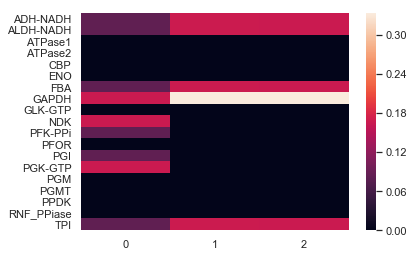

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
fng_data={}
for t in range(3):
    fng_data[t]={}
    for r in all_data[t]['mdf'].reaction_data:
        fng_data[t].update({r.reaction.reaction_id: float(r.shadow_price)})
        print (r.reaction.reaction_id,r.shadow_price)
    k=0
    print(all_data[t]['mdf'].mdf)
    tem_c = all_data[t]['mdf'].compound_data    
    for c in tem_c:
        if c.shadow_price!=0:
            print(ktaDict[c.compound], c.concentration,all_data[t]['conc'][k],c.lb,c.ub,c.shadow_price)
        elif ktaDict[c.compound] in ["nadh","g3p","dhap"]:
            print(ktaDict[c.compound], c.concentration,all_data[t]['conc'][k],c.lb,c.ub,c.shadow_price)
        k=k+1
df = pd.DataFrame.from_dict(fng_data)
sns.heatmap(df)

ATPase1 0.0
CBP 0.0
GLK-GTP 0.0
PGMT 0.0
PGI 0.9999999999999971
PFK-PPi -1.792397723587727e-16
FBA -2.2453529990611263e-17
TPI -2.2453529990611263e-17
GAPDH -3.1070142163686827e-16
PGK-GTP 0.0
PGM -2.1465763262955037e-16
ENO 0.0
PPDK 0.0
PFOR 0.0
RNF_PPiase 0.0
ALDH-NADH 1.7711629321326827e-16
ADH-NADH -4.878177148501366e-16
NDK 0.0
ATPase2 0.0
h2o 1.0 (1.0, 1.0) 1.0 1.0
nad 0.00010000000000000026 (0.00010000000000000009, 0.00010000000000000009) 0.0001 0.0001
nadh 1.4841049718572852e-05 (6.675475189822201e-06, 1.4841049718573036e-05) 1e-06 0.01
adp 0.00010000000000000009 (0.00010000000000000026, 0.00010000000000000026) 0.0001 0.0001
pi 0.010000000000000004 (0.010000000000000014, 0.010000000000000014) 0.01 0.01
co2 1.0000000000000069e-05 (9.999999999999997e-06, 9.999999999999997e-06) 1e-05 1e-05
amp 0.00010000000000000063 (0.00010000000000000009, 0.00010000000000000009) 0.0001 0.0001
gdp 0.00010000000000000026 (0.00010000000000000009, 0.00010000000000000009) 0.0001 0.0001
f6p 0.00110455

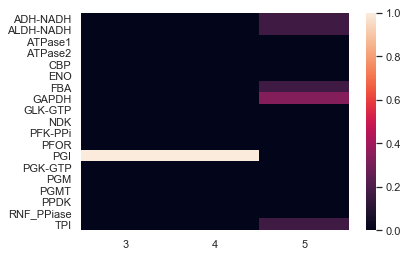

In [15]:
fng_data={}
for t in range(3,6):
    fng_data[t]={}
    for r in all_data[t]['mdf'].reaction_data:
        fng_data[t].update({r.reaction.reaction_id: float(r.shadow_price)})
        print (r.reaction.reaction_id,r.shadow_price)
    k=0
    tem_c = all_data[t]['mdf'].compound_data    
    for c in tem_c:
        if (all_data[t]['conc'][k][0]==all_data[t]['conc'][k][1]):
            print(ktaDict[c.compound], c.concentration,all_data[t]['conc'][k],c.lb,c.ub)
        elif ktaDict[c.compound] in ["nadh","g6p","f6p","g3p","dhap"]:
            print(ktaDict[c.compound], c.concentration,all_data[t]['conc'][k],c.lb,c.ub)
        k=k+1    
df = pd.DataFrame.from_dict(fng_data)
sns.heatmap(df)
print(fng_data[5])

ATPase1 0.0
CBP 0.0
GLK-GTP 0.0
PGMT 0.0
PGI 0.9999999999999964
PFK-PPi -1.792397723587727e-16
FBA 1.1714847019358735e-16
TPI 1.1714847019358735e-16
GAPDH 1.5702629629721642e-17
PGK-GTP 0.0
PGM -6.311044179916439e-16
ENO 0.0
PPDK 0.0
PFOR 0.0
RNF_PPiase 0.0
ALDH-NADH 4.973105530040435e-16
ADH-NADH -4.816079233743219e-16
NDK 3.979922444025623e-32
ATPase2 0.0
h2o 1.0 (1.0, 1.0) 1.0 1.0
nad 0.00010000000000000009 (0.00010000000000000009, 0.00010000000000000009) 0.0001 0.0001
nadh 3.161726801326779e-06 (3.161726801326773e-06, 1.1319982091534845e-05) 1e-06 0.01
adp 0.00010000000000000009 (0.00010000000000000009, 0.00010000000000000009) 0.0001 0.0001
pi 0.010000000000000004 (0.010000000000000014, 0.010000000000000014) 0.01 0.01
co2 9.999999999999997e-06 (9.999999999999997e-06, 9.999999999999997e-06) 1e-05 1e-05
amp 0.00010000000000000026 (0.00010000000000000009, 0.00010000000000000009) 0.0001 0.0001
gdp 0.00010000000000000009 (0.00010000000000000009, 0.00010000000000000009) 0.0001 0.0001
f6p

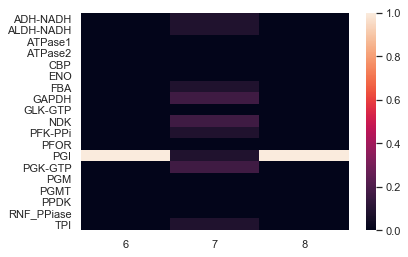

In [16]:
fng_data={}
for t in range(6,9):
    fng_data[t]={}
    for r in all_data[t]['mdf'].reaction_data:
        fng_data[t].update({r.reaction.reaction_id: float(r.shadow_price)})
        print (r.reaction.reaction_id,r.shadow_price)
    k=0
    tem_c = all_data[t]['mdf'].compound_data    
    for c in tem_c:
        if (all_data[t]['conc'][k][0]==all_data[t]['conc'][k][1]):
            print(ktaDict[c.compound], c.concentration,all_data[t]['conc'][k],c.lb,c.ub)
        elif ktaDict[c.compound] in ["nadh","g6p","f6p"]:
            print(ktaDict[c.compound], c.concentration,all_data[t]['conc'][k],c.lb,c.ub)
        k=k+1    
df = pd.DataFrame.from_dict(fng_data)
sns.heatmap(df)

h2o 1.0 (1.0, 1.0) 1.0 1.0
nad 0.00010000000000000026 (0.00010000000000000009, 0.00010000000000000009) 0.0001 0.0001
nadh 1.5441029124083103e-05 (2.2864256295987637e-06, 1.544102912408302e-05) 1e-06 0.01
adp 0.00010000000000000026 (0.00010000000000000026, 0.00010000000000000026) 0.0001 0.0001
pi 0.009999999999999978 (0.009999999999999986, 0.009999999999999986) 0.01 0.01
co2 9.999999999999997e-06 (9.99999999999998e-06, 9.99999999999998e-06) 1e-05 1e-05
amp 0.00010000000000000026 (0.00010000000000000009, 0.00010000000000000009) 0.0001 0.0001
gdp 0.00010000000000000026 (0.00010000000000000026, 0.00010000000000000026) 0.0001 0.0001
fdxox 0.00010000000000000009 (0.00010000000000000026, 0.00010000000000000026) 0.0001 0.0001
etoh 0.004347826086956521 (0.004347826086956524, 0.004347826086956524) 0.004347826086956522 0.004347826086956522
h2o 1.0 (1.0, 1.0) 1.0 1.0
nad 9.999999999999991e-05 (0.00010000000000000009, 0.00010000000000000009) 0.0001 0.0001
nadh 8.032632018996023e-06 (8.0326320189960

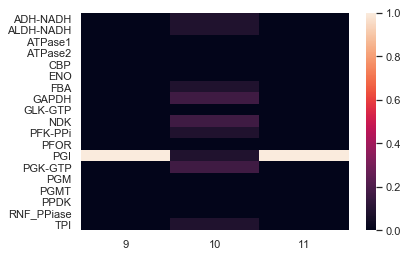

In [17]:
fng_data={}
for t in range(9,12):
    fng_data[t]={}
    for r in all_data[t]['mdf'].reaction_data:
        fng_data[t].update({r.reaction.reaction_id: float(r.shadow_price)})
        k=0
    tem_c = all_data[t]['mdf'].compound_data    
    for c in tem_c:
        if (all_data[t]['conc'][k][0]==all_data[t]['conc'][k][1]):
            print(ktaDict[c.compound], c.concentration,all_data[t]['conc'][k],c.lb,c.ub)
        elif ktaDict[c.compound] in ["nadh"]:
            print(ktaDict[c.compound], c.concentration,all_data[t]['conc'][k],c.lb,c.ub)
        k=k+1    
df = pd.DataFrame.from_dict(fng_data)
sns.heatmap(df)